In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, Sequential

In [2]:
(ds_train, ds_validation, ds_test), metadata  = tfds.load(
    "tf_flowers", 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    as_supervised=True, 
    with_info=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = metadata.features["label"].num_classes
labels = metadata.features["label"].names

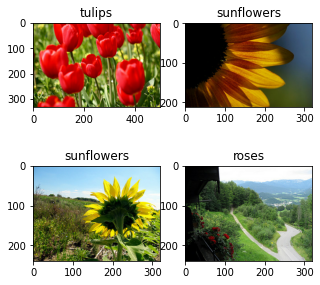

In [4]:
samples = ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    img_array, img_label_idx = img
    #print(np.min(img_array), np.max(img_array))
    ax = fig.add_subplot(2,2, i + 1)    
    ax.imshow(img_array)    
    ax.set_title(labels[img_label_idx])
plt.show()

In [66]:
vgg_model = VGG19(weights='imagenet') 
vgg_input = vgg_model.input
vgg_layers = vgg_model.layers
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [67]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
import json

h,w,depth = vgg_input.shape[1:]
samples = ds_train.take(4)
for img, label in samples:     
    img = tf.image.resize(img, (h,w))
    img = tf.expand_dims(img,0)
    img = preprocess_input(img)
    preds = vgg_model(img)
    classIdx = tf.argmax(preds, axis=1).numpy()
    print(decode_predictions(preds.numpy(), top=10))

[[('n03930313', 'picket_fence', 0.7801133), ('n07720875', 'bell_pepper', 0.17049098), ('n03047690', 'clog', 0.02374545), ('n01833805', 'hummingbird', 0.004085722), ('n11939491', 'daisy', 0.003977443), ('n03457902', 'greenhouse', 0.0038081845), ('n12985857', 'coral_fungus', 0.0029790949), ('n07615774', 'ice_lolly', 0.0018276226), ('n03000134', 'chainlink_fence', 0.0012916143), ('n02782093', 'balloon', 0.0010944458)]]
[[('n11939491', 'daisy', 0.96014893), ('n02206856', 'bee', 0.019139342), ('n01944390', 'snail', 0.0030547956), ('n02190166', 'fly', 0.0009329777), ('n03065424', 'coil', 0.0008636174), ('n07734744', 'mushroom', 0.00086006144), ('n02219486', 'ant', 0.0007601232), ('n02165456', 'ladybug', 0.0007216358), ('n07749582', 'lemon', 0.00069221394), ('n02280649', 'cabbage_butterfly', 0.00068543723)]]
[[('n11939491', 'daisy', 0.24668871), ('n11879895', 'rapeseed', 0.062125478), ('n03930313', 'picket_fence', 0.057592615), ('n03991062', 'pot', 0.042212863), ('n09332890', 'lakeside', 0.02

In [70]:
layer_outputs = [layer.output for layer in vgg_layers]
new_model = Model(inputs = vgg_input, outputs= layer_outputs)
feature_extraction_model = Model(inputs=new_model.input, outputs=new_model.get_layer("block1_pool").output)
samples = ds_train.take(4)
for img, label in samples:  
    img = tf.image.resize(img, (h,w))
    img = tf.expand_dims(img,0)
    img = preprocess_input(img)
    feature_maps = feature_extraction_model(img)
    print(feature_maps.shape)


(1, 112, 112, 64)
(1, 112, 112, 64)
(1, 112, 112, 64)
(1, 112, 112, 64)


In [76]:
vgg_trained_model = VGG19(
    weights="imagenet",
    include_top=False
)

def get_vgg_maxpooling_layers():
    return [layer for layer
        in vgg_trained_model.layers
            if isinstance(layer, layers.MaxPooling2D )
    ]
    
for layer in get_vgg_maxpooling_layers():        
    model = Model(
            inputs=vgg_trained_model.input,
            outputs=layer.output)  
    for img, label in samples:  
        img = tf.image.resize(img, (h,w))
        img = tf.expand_dims(img,0)
        img = preprocess_input(img)
        feature_maps = model(img) 
        print(feature_maps.shape)

(1, 112, 112, 64)
(1, 112, 112, 64)
(1, 112, 112, 64)
(1, 112, 112, 64)
(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 7, 7, 512)
(1, 7, 7, 512)
(1, 7, 7, 512)
(1, 7, 7, 512)
